# pipeline - gonogo data, clean areas

This notebook acts as the finalized pipeline for processing the full GoNoGo recordings, and computes PSDs, slopes, and outputs a samples-feature matrix for statistical analysis. The analysis grabs segments from the recording which have been marked as clean. Data has been preprocessed in MATLAB using the parameters and functions specified at `../../data/GNG/pipeline.txt`

The notebook is divided into the following sections:
0. **Parameters:** Parameter selection for running the analysis.
1. **PSD Calculations:** Loading subject PSDs for both older and younger adults.
2. **Fit to PSD Slopes:** Fitting to specified frequency range with specified fitting method (either simple linear regression or RANSAC).
3. **Construct Samples-Features Matrix:** Exporting results to a samples-features matrix, for statistical analysis.

In [1]:
%matplotlib inline
import os
import glob
import datetime
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io
import numpy.fft
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn import linear_model
mpl.rcParams['figure.figsize'] = (16, 10)

## Parameters
- `recompute_psds`: `True` or `False`, for recomputing subject PSDs or loading previous results.
- `psd_buffer_lofreq`: Scalar, specifies the lower bound for the PSD buffer that we exclude.
- `psd_buffer_hifreq`: Scalar, specifies the upper bound for the PSD buffer that we exclude.
- `fitting_func`: `'linreg'` or `'ransac'`, specifies which function to use for fitting. `'linreg'` is simple linear regression. `'ransac'` is RANSAC, a robust fitting method that ignores outliers.
- `fitting_lofreq`: Scalar, specifies the lower bound for the PSD fitting range.
- `fitting_hifreq`: Scalar, specifies the upper bound for the PSD fitting range.
- `import_dir`: String specifying the directory to import results to.
- `export_dir`: String specifying the directory to export results to.

In [2]:
recompute_psds = True
psd_buffer_lofreq = 7
psd_buffer_hifreq = 14
fitting_func = 'ransac'
fitting_lofreq = 2
fitting_hifreq = 24
import_dir = '/Volumes/luc/_psd-slope/data/GNG/ExclFiltCARClust-mat/'
export_dir = '/Volumes/luc/_psd-slope/data/GNG/'

##### Set up workspace, print out parameters to text file...

In [3]:
current_time = '-'.join('_'.join(str(datetime.datetime.now()).split()).split(':'))[:-7]
export_dir = export_dir + current_time + '/'
os.mkdir(export_dir)
params = open(export_dir + 'parameters.txt', 'w')
params.write('recompute_psds = ' + str(recompute_psds))
params.write('\npsd_buffer_lofreq = ' + str(psd_buffer_lofreq))
params.write('\npsd_buffer_hifreq = ' + str(psd_buffer_hifreq))
params.write('\nfitting_func = ' + str(fitting_func))
params.write('\nfitting_lofreq = ' + str(fitting_lofreq))
params.write('\nfitting_hifreq = ' + str(fitting_hifreq))
params.write('\nimport_dir = ' + str(import_dir))
params.write('\nexport_dir = ' + str(export_dir))
params.close()

## Subject Importing & PSD Calculations

This section imports subject information and computes PSDs using Welch's method. The algorithm proceeds as follows, for each channel:
1. Extract as many clean 2-second eyes closed and eyes open segments from the recording. Segments overlap by 50%.
2. Multiply each 2-second segment by a 2-second Hamming window. 
3. Compute the discrete Fourier transform of each segment, and average DFT'd segments to arrive at a per-channel PSD.

The PSD is defined as:
$$
PSD = log_{10}(\sum\limits_{n=1}^{N}{N})
$$

##### Function Definitions

In [4]:
def get_filelist(import_path):
    matfiles = []
    for root, dirs, files in os.walk(import_path):
        matfiles += glob.glob(os.path.join(root, '*.mat'))
    return matfiles

def import_subject(subj, i, import_path):
    """ 
    Imports a single subject and adds them to the subj
    data structure. Additionally, merges 
    """
    subj[i] = {}
    datafile = sp.io.loadmat(import_path)
    subj[i]['name'] = str(np.squeeze(datafile['name']))
    subj[i]['srate'] = int(np.squeeze(datafile['srate']))
    subj[i]['events'] = []
    for event in np.squeeze(datafile['evts']):
        subj[i]['events'].append([event[0][0], event[1][0][0], event[2][0][0]])
    subj[i]['data'] = np.squeeze(datafile['data'])
    subj[i]['nbchan'] = len(subj[i]['data'])
    return subj

def _print_window_info(events, port_code):
    evts = [[events[i][1], events[i+1][1]] for i in range(len(events)) if events[i][0] == port_code]
    total_wins = 0
    total_secs = 0
    for e in evts:
        if (e[1] - e[0]) >= 1024:
            pts  = e[1] - e[0]
            secs = (e[1] - e[0])//512
            nwin = (e[1] - e[0])//512 - 1
            total_wins += nwin
            total_secs += secs
            print('Event {}:\t{} points, {} seconds, {} windows'.format(e, pts, secs, nwin))
    print('Total windows able to be extracted: ', total_wins)

def welch(windows, srate):
    """
    Takes a list of data segments (each size 1xN), computes each segment's PSD,
    and averages them to get a final PSD.
    """
    psds = [sp.signal.welch(window, srate, nperseg=len(window), window='hamming')[1] for window in windows]
    return np.mean(psds, axis=0)
    
def remove_freq_buffer(data, lofreq, hifreq):
    """
    Removes a frequency buffer from a PSD or frequency vector.
    """
    data = np.delete(data, range(lofreq*2, hifreq*2))
    return data.reshape(len(data), 1)

def get_windows(data, events, port_code, nperwindow=512*2, noverlap=512):
    windows = []
    # The following line restructures events of type port_code into the 
    # following format:
    #         [start_time, end_time]
    evts = [[events[i][1], events[i+1][1]] for i in range(len(events)) if events[i][0] == port_code]
    for event in evts:
        if event[1]-event[0] >= nperwindow:
            nwindows = (event[1] - event[0])//noverlap - 1
            for i in range(nwindows):
                windows.append(data[event[0] + noverlap*i : event[0] + noverlap*i + nperwindow])
    return windows

def compute_subject_psds(import_path, import_path_csv):
    """ Returns subj data structure with calculated PSDs and subject information.
    Arguments:
        import_path:     String, path to .mat files
        import_path_csv: String, path to .csv containing subject class, sex, and
                         age information. 
    """
    matfiles = get_filelist(import_path)
    df = pd.read_csv(import_path_csv)
    df.SUBJECT = df.SUBJECT.astype(str)

    subj = {}
    subj['nbsubj'] = len(matfiles)
    subj['f'] = np.linspace(0, 256, 513)
    subj['f'] = subj['f'].reshape(len(subj['f']), 1)
    subj['f_rm_alpha'] = remove_freq_buffer(subj['f'], 7, 14)
    for i in range(len(matfiles)):
        
        subj = import_subject(subj, i, matfiles[i])
        subj[i]['age']   = df[df.SUBJECT == subj[i]['name']].AGE.values[0]
        subj[i]['class'] = df[df.SUBJECT == subj[i]['name']].CLASS.values[0]
        subj[i]['sex']   = df[df.SUBJECT == subj[i]['name']].SEX.values[0]

        for ch in range(subj[i]['nbchan']):
            subj[i][ch] = {}
            windows = get_windows(subj[i]['data'][ch], subj[i]['events'], 'C1')
            subj[i][ch]['psd'] = welch(windows, 512)
            subj[i][ch]['psd_rm_alpha'] = remove_freq_buffer(subj[i][ch]['psd'], 7, 14)
        subj[i]['nwindows'] = len(windows)
        subj[i]['data'] = np.nan # No longer needed, so clear it from memory
        subj[i]['psd'] = np.mean([subj[i][ch]['psd'] for ch in range(subj[i]['nbchan'])], axis=0)
        subj[i]['psd_rm_alpha'] = remove_freq_buffer(subj[i]['psd'], 7, 14)
        print("Processed: ", subj[i]['name'])
    subj['psd'] = np.mean([subj[i]['psd'] for i in range(subj['nbsubj'])], axis=0)
    return subj

##### Processing

In [5]:
if recompute_psds == True:
    # Import EEG for older and younger adults, compute PSDs
    subjoa = compute_subject_psds(import_dir_oa, '../../data/GNG/ya-oa-gng.csv')
    subjya = compute_subject_psds(import_dir_ya, '../../data/GNG/ya-oa-gng.csv')

    # Save resulting PSDs
    subjoa['time_computed'] = current_time
    subjya['time_computed'] = current_time
    np.save(export_dir + 'subjoa-no-fitting.npy', subjoa); subjoa = []
    np.save(export_dir + 'subjya-no-fitting.npy', subjya); subjya = []
else:
    # Use files with pre-computed PSDs and a 7 - 14 Hz buffer
    !cp /Users/jorge/Dropbox/research/_psd-slope/data/GNG/subjoa-no-fitting.npy $export_dir
    !cp /Users/jorge/Dropbox/research/_psd-slope/data/GNG/subjya-no-fitting.npy $export_dir

Processed:  120132101
Processed:  120132104
Processed:  120132107
Processed:  120132108
Processed:  120132109
Processed:  120132110
Processed:  120132111
Processed:  120132112
Processed:  120132113
Processed:  120132114
Processed:  120132116
Processed:  120132117
Processed:  120132119
Processed:  120132120
Processed:  120132121
Processed:  120132122
Processed:  120132123
Processed:  120132128
Processed:  120132130
Processed:  120132133
Processed:  120132137
Processed:  120132138
Processed:  120132139
Processed:  120132140
Processed:  120132142
Processed:  120132144
Processed:  120132145
Processed:  120132148
Processed:  120132149
Processed:  120132151
Processed:  120132153
Processed:  120132154
Processed:  120132155
Processed:  120132157
Processed:  120132160
Processed:  120132161
Processed:  120132162
Processed:  120132163
Processed:  120132165
Processed:  120132169
Processed:  112113113
Processed:  112113115
Processed:  1121131181
Processed:  1121131183
Processed:  1121131221
Process

## Fit to Spectral Slopes

Now we compute PSD slopes for each channel of each subject, and additionally calculate each subject's mean PSD slope. This is found by fitting to the grand average PSD of each subject.

##### Function Definitions

In [6]:
def linreg_slope(f, psd, lofreq, hifreq):
    """
    Fits line to the PSD, using simple linear regression.
    Returns slope and fit line.
    """
    model = linear_model.LinearRegression()
    model.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
    fit_line = model.predict(f)
    return model.coef_[0] * (10**2), fit_line

def ransac_slope(f, psd, lofreq, hifreq):
    """
    Robustly fits line to the PSD, using the RANSAC algorithm. 
    Returns slope and fit line.
    """
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
    fit_line = model_ransac.predict(f)
    return model_ransac.estimator_.coef_[0] * (10**2), fit_line

def fit_slopes(subj, regr_func, lofreq, hifreq):
    """ 
    Takes subj data structure and fits slopes to each subject's PSDs and mean
    PSD, using regr_func and fitting to datapoints between lofreq and hifreq.
    """
    # Fitting on the grand average PSD of all subjects
    subj['slope'], subj['fitline'] = regr_func(subj['f'], subj['psd'], lofreq, hifreq)
    for i in range(subj['nbsubj']):
        # Per-subject PSD average fitting
        subj[i]['slope'], subj[i]['fitline'] = regr_func(subj['f'], subj[i]['psd'], lofreq, hifreq)
        for ch in range(subj[i]['nbchan']):
            # Per-channel PSD fitting
            subj[i][ch]['slope'], subj[i][ch]['fitline'] = regr_func(subj['f'], subj[i][ch]['psd_rm_alpha'], lofreq, hifreq)
    return subj

##### Processing

In [7]:
# Select fitting function
if fitting_func == 'linreg':
    regr = linreg_slope
elif fitting_func == 'ransac':
    regr = ransac_slope

# Load subject PSDs
if recompute_psds == True:
    subjoa = np.load(export_dir + '/subjoa-no-fitting.npy').item()
    subjya = np.load(export_dir + '/subjya-no-fitting.npy').item()
else:
    subjoa = np.load('../../data/pipeline-full/subjoa-no-fitting.npy').item()
    subjya = np.load('../../data/pipeline-full/subjya-no-fitting.npy').item()
    
# Fit lines to slopes using specified function and frequency range
subjoa = fit_slopes(subjoa, regr, fitting_lofreq, fitting_hifreq)
subjya = fit_slopes(subjya, regr, fitting_lofreq, fitting_hifreq)

# Save results
oa_filename = export_dir + 'subjoa-' + str(fitting_lofreq) + '-' + str(fitting_hifreq) + '-' + fitting_func + '.npy'
ya_filename = export_dir + 'subjya-' + str(fitting_lofreq) + '-' + str(fitting_hifreq) + '-' + fitting_func + '.npy'
subjoa['time_computed'] = current_time
subjya['time_computed'] = current_time
np.save(oa_filename, subjoa); subjoa = []
np.save(ya_filename, subjya); subjya = []

/Users/jorge/Development/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## Construct Samples-Features Matrix

Now we construct the samples-features matrix containing the calculated slopes. We use a table that already contains subject numbers, sex, age, and memory class to start off.

##### Function Definitions

In [8]:
def get_subject_slopes(subj, ch, slope_type):
    """ Returns list of slopes for specified channel of slope_type.
    Arguments:
        subj: The subj data structure.
        ch:   Scalar, channel for which to get list of subject slopes.
        slope_type: String, e.g., 'eyesO_slope' or 'eyesC_slope'
    """
    if ch == -1: # Slope of PSD grand average
        return [subj[i][slope_type]     for i in range(subj['nbsubj'])]
    else:
        return [subj[i][ch][slope_type] for i in range(subj['nbsubj'])]

##### Processing

In [9]:
# Define channels, these will form labels for our table:
channels = ["A1","A2","A3","A4","A5","A6","A7","A8","A10","A11","A12","A13","A14","A15","A16","A17","A18","A21","A22","A23","A24","A25","A26","A27","A29","A30","A31","B1","B2","B3","B4","B5","B6","B8","B9","B10","B11","B12","B13","B14","B17","B18","B19","B20","B21","B22","B23","B24","B26","B27","B28","B29","B30","FRONTAL","LTEMPORAL","CENTRAL","RTEMPORAL","OCCIPITAL"]

# Load subject PSDs with fitted slopes
subjoa = np.load(oa_filename).item()
subjya = np.load(ya_filename).item()

# Construct matrix
data = {}
oa_names = [subjoa[i]['name'] for i in range(subjoa['nbsubj'])]
ya_names = [subjya[i]['name'] for i in range(subjya['nbsubj'])]
data['SUBJECT'] = np.concatenate([oa_names, ya_names], axis=0)

oa_class = [subjoa[i]['class'] for i in range(subjoa['nbsubj'])]
ya_class = [subjya[i]['class'] for i in range(subjya['nbsubj'])]
data['CLASS'] = np.concatenate([oa_class, ya_class], axis=0)

oa_age = [subjoa[i]['age'] for i in range(subjoa['nbsubj'])]
ya_age = [subjya[i]['age'] for i in range(subjya['nbsubj'])]
data['AGE'] = np.concatenate([oa_age, ya_age], axis=0)

df = pd.DataFrame(data)
df = df[['SUBJECT', 'CLASS', 'AGE']]

# Add total number of windows extracted for each subject
oa_windows = [subjoa[i]['nwindows'] for i in range(subjoa['nbsubj'])]
ya_windows = [subjya[i]['nwindows'] for i in range(subjya['nbsubj'])]
df['N_WINDOWS'] = np.concatenate([oa_windows, ya_windows], axis=0)

# Add each subject's mean slope.
oa_avg_psd = get_subject_slopes(subjoa, -1, 'slope')
ya_avg_psd = get_subject_slopes(subjya, -1, 'slope')
df['AVG_PSD'] = np.concatenate([oa_avg_psd, ya_avg_psd], axis=0)

# Now add slopes for every channel from each subject.
for ch in range(len(channels)):
    oa_psd = get_subject_slopes(subjoa, ch, 'slope')
    ya_psd = get_subject_slopes(subjya, ch, 'slope')
    df[channels[ch]] = np.concatenate([oa_psd, ya_psd], axis=0)

# Export results
filename = export_dir + 'ya-oa-gng-' + fitting_func + '-' + str(fitting_lofreq) + '-' + str(fitting_hifreq) + '.csv'
print('Saving fitted slopes at:\n{}'.format(filename))
df.to_csv(filename, index=False)

Saving fitted slopes at:
/Volumes/luc/_psd-slope/data/GNG/2016-10-27_01-04-21/ya-oa-gng-ransac-2-24.csv


## A bit of visualization

In [10]:
# oa_psd = np.mean([subjoa[i][]], axis=0)

(0, 30)

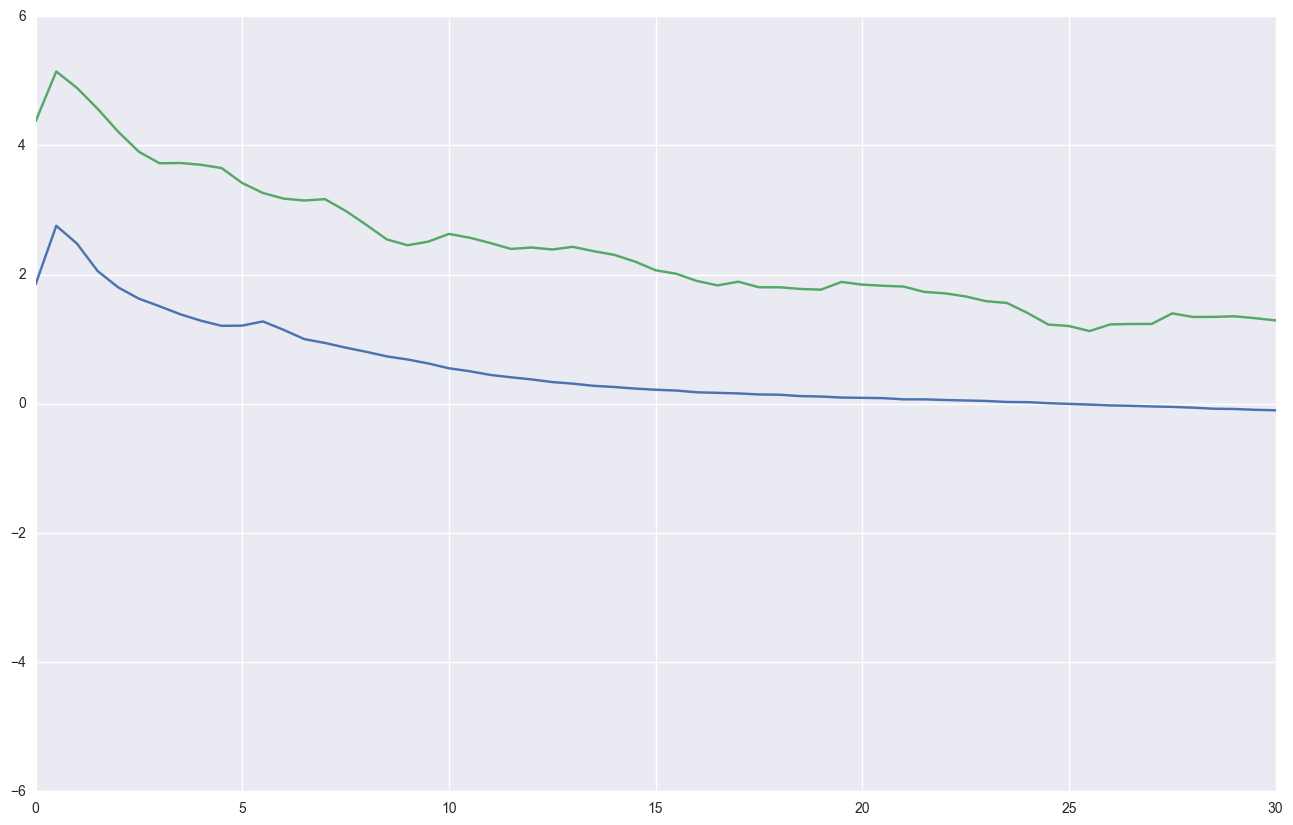

In [11]:
oa_psd = np.mean([subjoa[i]['psd'] for i in range(subjoa['nbsubj'])], axis=0)
ya_psd = np.mean([subjya[i]['psd'] for i in range(subjya['nbsubj'])], axis=0)

plt.plot(subjoa['f'], np.log10(oa_psd))
plt.plot(subjya['f'], np.log10(ya_psd))
plt.xlim([0, 30])

(0, 30)

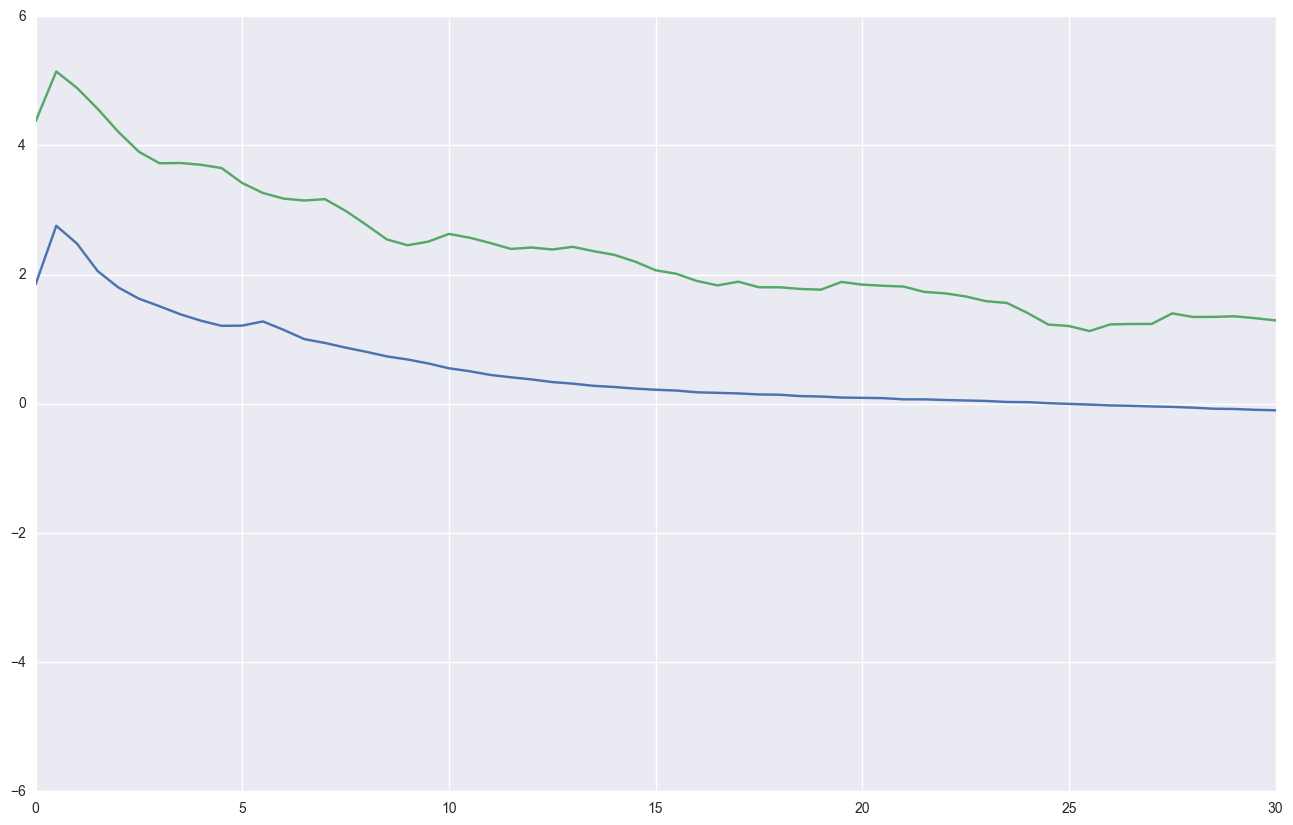

In [12]:
for i in range(subjoa['nbsubj']):
    subjoa[i]['avg_psd'] = np.mean([subjoa[i][ch]['psd'] for ch in range(subjoa[i]['nbchan'])], axis=0)
for i in range(subjya['nbsubj']):
    subjya[i]['avg_psd'] = np.mean([subjya[i][ch]['psd'] for ch in range(subjya[i]['nbchan'])], axis=0)
oa_psd = np.mean([subjoa[i]['avg_psd'] for i in range(subjoa['nbsubj'])], axis=0)
ya_psd = np.mean([subjya[i]['avg_psd'] for i in range(subjya['nbsubj'])], axis=0)

plt.plot(subjoa['f'], np.log10(oa_psd))
plt.plot(subjya['f'], np.log10(ya_psd))
plt.xlim([0, 30])

(0, 40)

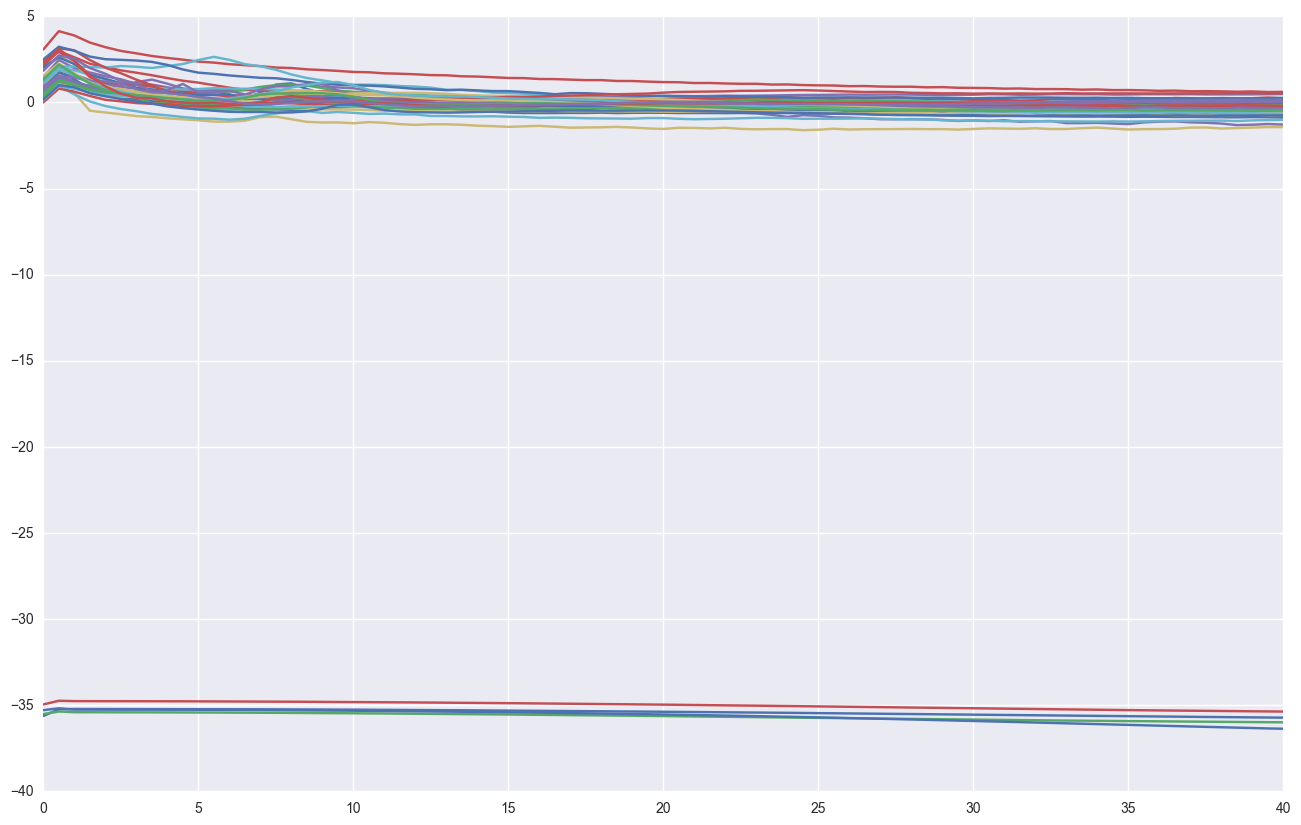

In [13]:
for i in range(subjoa['nbsubj']):
    plt.plot(subjoa['f'], np.log10(subjoa[i]['avg_psd']))
plt.xlim([0, 40])